### **PROYECTO DEEPLEARNING**

Lo primero que haremos para el proyecto es poner todos los import necesarios y hacer la configuración del entorno de desarrollo, mostramos la version de python, pytorch que estamos usando y nos aseguramos de que estamos usando correctamente la gráfica para el modelo.

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from PIL import Image, ImageDraw

# Configuración del dispositivo
print(f'Python version info: {sys.version}')
print(f'PyTorch version info: {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU name: {torch.cuda.get_device_name(0)}')

# Fijar semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

Python version info: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
PyTorch version info: 2.5.1
Using device: cuda
GPU name: NVIDIA GeForce RTX 2080 SUPER


A continuación cargare los dataset tanto el de imágenes como el de POI y hare un análisis exploratorio de ambos para ver en que estado se encuentran los datos y decidir como tengo que tratarlos y poder visualizar que tipo de datos tenemos para trabajar y entrenar el modelo.

In [2]:
# Guardamos la ruta de los dataset que emplearemos y los cargamos
poi_df_path = 'poi_dataset.csv'
image_base_path = 'data_main'

poi_df = pd.read_csv(poi_df_path)

In [3]:
# Sacamos la información que hay en el dataset
print("\n--- Información del Dataset ---")
poi_df.info()


--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


Tras comprobar con el .info() que la columna tags se encuentra como objeto, más adelante tendre que pensar como solucionar que estos datos se encuetren así ya que tenemos que modificarlo a la hora de realizar el modelo.

In [4]:
# Saco las primeras 5 filas del dataset para poder ver como se encuentran los datos visualmente
print("\n--- Primeras Filas del Dataset ---")
poi_df.head(5)


--- Primeras Filas del Dataset ---


,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


In [5]:
# Saco las estadísticas que me describiran como se encuentra el dataset
print("\n--- Estadísticas Descriptivas ---")
poi_df.describe()


--- Estadísticas Descriptivas ---


,tier,locationLon,locationLat,xps,Visits,Likes,Dislikes,Bookmarks
count,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000
mean,1.541109,-1.132337,39.900141,750.382409,10011.943276,3623.908222,2526.305927,973.261950
std,0.637677,22.733401,9.662134,228.319854,5.456808,4817.879374,2225.543360,1453.333948
min,1.000000,-121.951049,-62.940930,0.000000,10001.000000,100.000000,52.000000,50.000000
25%,1.000000,-3.725292,40.411754,600.000000,10008.000000,464.000000,937.000000,116.000000
50%,1.000000,-3.699140,40.421738,700.000000,10011.000000,1434.000000,2718.000000,306.000000
75%,2.000000,-3.673348,40.472458,1000.000000,10015.000000,6840.000000,3399.000000,1309.000000
max,4.000000,158.333118,65.706572,1000.000000,10038.000000,26425.000000,10999.000000,8157.000000


In [6]:
# Compruebo si hay nulos o no
print("\n--- Datos Faltantes ---")
poi_df.isnull().sum()


--- Datos Faltantes ---


id                  0
name                0
shortDescription    0
categories          0
tier                0
locationLon         0
locationLat         0
tags                0
xps                 0
Visits              0
Likes               0
Dislikes            0
Bookmarks           0
main_image_path     0
dtype: int64

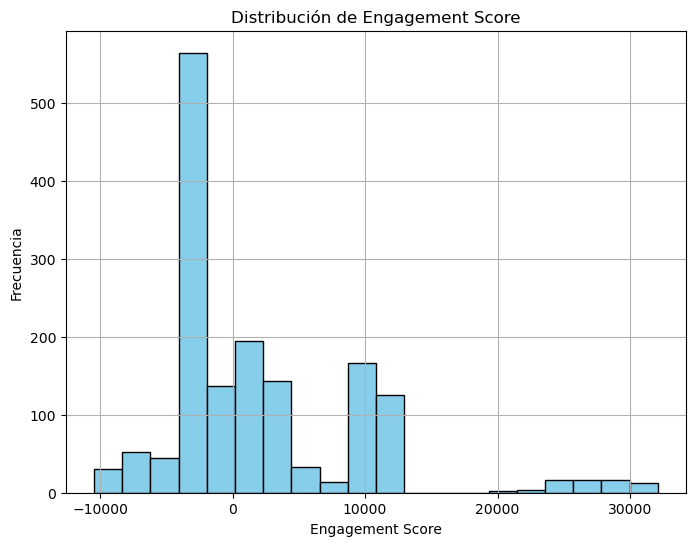

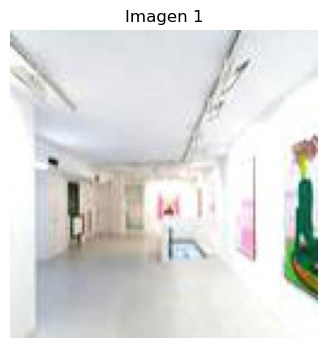

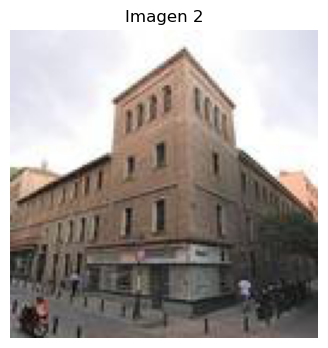

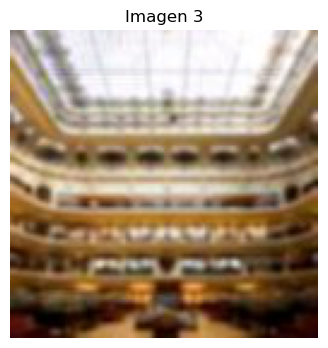

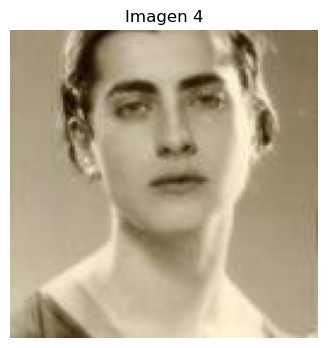

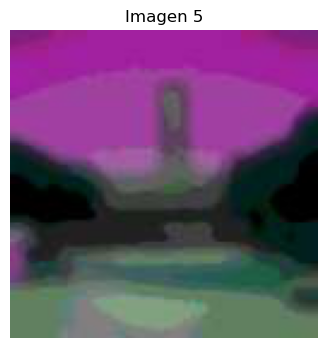

In [7]:
# Visualizo distribución de engagement
poi_df['engagement_score'] = poi_df['Likes'] - poi_df['Dislikes'] + poi_df['Bookmarks']
plt.figure(figsize=(8, 6))
poi_df['engagement_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de Engagement Score')
plt.xlabel('Engagement Score')
plt.ylabel('Frecuencia')
plt.show()

# Mostrar 5 imágenes de muestra
image_paths = poi_df['main_image_path'].apply(lambda x: os.path.join(image_base_path, x)).values[:5]
for i, img_path in enumerate(image_paths):
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Imagen {i+1}")
    plt.axis('off')
    plt.show()

Con el código anterior combino las interacciones que me parecen positivas (likes y bookmarks) y le resto las negativas (dislikes) para obtener la métrica general que mide el niuvel de engagement en cada punto de interés. Este calculo me da una idea del interés quie generan los POI. 

Observo que la mayoría de los valores están concentrados cerca de 0, lo que me da a entender que la mayoría de los POI tienen niveles de engagement moderados o bajos, las columnas que podemos ver mas a la derecha representan a POI con mucho engagement, pero son bastante menos frecuentes que los demas. También puedo observar que hay valores negativos los cuales me indican que hay POI con más interacciones negativas que positivas.

Con la distribución del engagement puedo identificar tendencias o desequilibrios en los datos.

In [8]:
# Crear la métrica binaria de engagement
engagement_threshold = poi_df['engagement_score'].quantile(0.75)
poi_df['high_engagement'] = (poi_df['engagement_score'] >= engagement_threshold).astype(int)

# Convertir tags en listas y generar un vocabulario
poi_df['tags_list'] = poi_df['tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
unique_tags = list(set(chain(*poi_df['tags_list'])))
tag_to_idx = {tag: idx for idx, tag in enumerate(unique_tags)}
vocab_size = len(tag_to_idx)

# Convertir cada tag en índices y aplicar padding
max_len = max(poi_df['tags_list'].apply(len))
poi_df['tags_indices'] = poi_df['tags_list'].apply(lambda tags: [tag_to_idx[tag] for tag in tags])
poi_df['tags_padded'] = poi_df['tags_indices'].apply(lambda indices: indices + [0] * (max_len - len(indices)))

# Filtrar imágenes existentes
poi_df['image_path'] = poi_df['main_image_path'].apply(lambda x: os.path.join(image_base_path, x))
poi_df = poi_df[poi_df['image_path'].apply(os.path.exists)]

En este paso transformo el problema en una clasificación binaria, le he dado los siguientes valores:

high_engagement = 1 indica un POI con alto engagement.
high_engagement = 0 indica un POI con bajo engagement.

al poner quantile(0.75) me aseguro de que el 25 % de los POI con mayor engagement se etiqueten como "alto engagement", lo cual me es útil para enfocarme en los POI más populares.

Los tags asociados a cada POI son cadenas de texto. Para utilizarlos como entrada en un modelo, necesito convertirlos en representaciones numéricas. Debido a esto he decidido usar split(',') para separar los tags en una lista, lo que facilita procesarlos como datos categóricos. Creo un vocabulario único usando "set" y "chain" para identificar todos los tags únicos en el data set y asigno un ídice numérico a cada tag con tad_to_idx.

Después de esto he decidido convertir cada tag e índices y aplicar padding, ya que en deep learning las entradas se esperan que sean de una longitud fija.

Por último combino la ruta base con la ruta relativa para obtener rutas completas y asegurarme de que todas las imágenes esten disponibles.

In [9]:
# Dividir en conjuntos de entrenamiento, validación y prueba
train_poi_df, temp_poi_df = train_test_split(
    poi_df, test_size=0.3, random_state=42, stratify=poi_df['high_engagement']
)
val_poi_df, test_poi_df = train_test_split(
    temp_poi_df, test_size=0.5, random_state=42, stratify=temp_poi_df['high_engagement']
)

print(f"Tamaño del conjunto de entrenamiento: {len(train_poi_df)}")
print(f"Tamaño del conjunto de validación: {len(val_poi_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_poi_df)}")

Tamaño del conjunto de entrenamiento: 1098
Tamaño del conjunto de validación: 235
Tamaño del conjunto de prueba: 236


Ahora he dividido el data set en 70 % para train y 30 % para test y validation (siendo un 15 % para test y el otro 15 % para validation), al usar stratify también me aseguro de que las proporciones de las clases(high_engagement) sean representativas en cada conjunto.

In [10]:
class POIDataset(Dataset):
    def __init__(self, poi_df, transform=None):
        self.poi_df = poi_df
        self.transform = transform

    def __len__(self):
        return len(self.poi_df)

    def __getitem__(self, idx):
        row = self.poi_df.iloc[idx]
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        metadata = torch.tensor([row['locationLon'], row['locationLat']], dtype=torch.float32)
        tags = torch.tensor(row['tags_padded'], dtype=torch.long)
        label = torch.tensor(row['high_engagement'], dtype=torch.long)

        return {'image': image, 'metadata': metadata, 'tags': tags, 'label': label}

La clase POIDataset extiende la clase Dataset de PyTorch para gestionar tus datos personalizados. Esta clase permite que el modelo reciba entradas en formato compatible, combinando imágenes, metadatos y etiquetas.

In [11]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

A continuación he transformado las imágenes para que su formato y tamaño sea compatible con el modelo y asi puedo mejorar la generalización del modelo.

In [12]:
# Crear datasets y DataLoaders
train_dataset = POIDataset(train_poi_df, transform=train_transform)
val_dataset = POIDataset(val_poi_df, transform=val_transform)
test_dataset = POIDataset(test_poi_df, transform=val_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Uso los dataloader porque en lugar de cargar todos los datos a la vez (lo cual sería ineficiente y consumiría mucha memoria), los dataloaders me ayudan a cargar los datos en lotes de tamaño fijo de esta manera puedo optimizar el uso de memoria y acelerar el entrenamiento.

Los DataLoaders aplican las transformaciones definidas en tu POIDataset (como el resize, normalización y data augmentation de las imágenes) automáticamente al cargar cada lote, esto elimina la necesidad de preprocesar manualmente los datos antes de cada iteración.

In [13]:
batch = next(iter(train_loader))
print("Imagenes batch shape:", batch['image'].shape)
print("Metadatos batch shape:", batch['metadata'].shape)
print("Tags batch shape:", batch['tags'].shape)
print("Etiquetas batch shape:", batch['label'].shape)

Imagenes batch shape: torch.Size([16, 3, 224, 224])
Metadatos batch shape: torch.Size([16, 2])
Tags batch shape: torch.Size([16, 14])
Etiquetas batch shape: torch.Size([16])


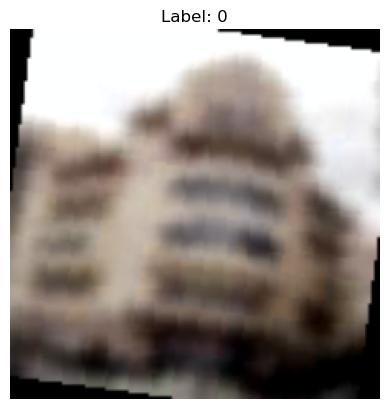

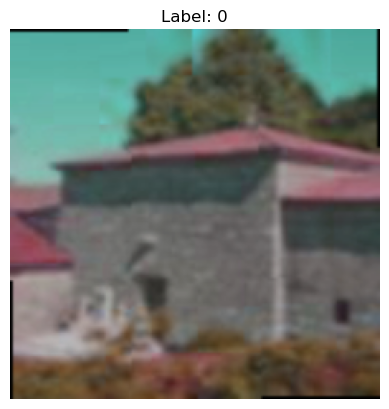

In [14]:
def show_images(images, labels, n=2):
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # Cambiar orden de ejes y convertir a numpy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Desnormalizar
        img = (img * 255).astype('uint8')  # Escalar a valores de píxeles
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
        plt.show()

batch = next(iter(train_loader))
show_images(batch['image'], batch['label'])

In [15]:
class HybridModel(nn.Module):
    def __init__(self, num_metadata_features, vocab_size, embedding_dim=32, num_classes=2):
        super(HybridModel, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()

        self.metadata_fc = nn.Sequential(
            nn.Linear(num_metadata_features, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.tags_fc = nn.Sequential(
            nn.Linear(embedding_dim, 8),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048 + 8 + 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, images, metadata, tags):
        cnn_features = self.cnn(images)
        metadata_features = self.metadata_fc(metadata)
        tags_embedding = self.embedding(tags).mean(dim=1)
        tags_features = self.tags_fc(tags_embedding)
        combined = torch.cat((cnn_features, metadata_features, tags_features), dim=1)
        return self.classifier(combined)

Utilizo un modelo ResNet50 preentrenado en ImageNet como extractor de las características para las imágenes, los metadatos se procesan mediante una red fully connected compuesta de la siguiente manera:

- Una capa lineal que reduce las dimensiones a 16.
- Una activación ReLU para introducir no linealidad.
- Un Dropout del 30% para reducir el riesgo de sobreajuste.
- Otra capa lineal que reduce las dimensiones a 8.
- Una activación ReLU final.

Los tags que están asociados a los datos los convertimos en representaciones numéricas utilizando una capa de embedding. 

Para terminar las características extraídas de las imágenes, metadatos y tags se concatenan en un único vector combinado de tamaño 2048 + 8 + 8 = 2064, el vector combinado lo pasamos por un clasificador que esta compuesto por:

- Una capa lineal que reduce las dimensiones a 128.
- Una activación ReLU para introducir no linealidad.
- Un Dropout del 50% para prevenir sobreajuste.
- Una capa lineal que reduce las dimensiones a num_classes=2, representando las clases de salida (por ejemplo, high_engagement y low_engagement).

Y ya por último usamnos Foward Pass para describir como los datos fluyen através del modelo durante la predicción.

In [16]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for batch in dataloader:
        images = batch['image'].to(device)
        metadata = batch['metadata'].to(device)
        tags = batch['tags'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata, tags)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            tags = batch['tags'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, metadata, tags)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    return total_loss / len(dataloader), correct / len(dataloader.dataset)


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50):
    best_val_loss = float('inf')
    patience = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Guardar el mejor modelo
        else:
            patience += 1
            if patience >= 10:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [17]:
# Inicializar el modelo
model = HybridModel(num_metadata_features=2, vocab_size=len(tag_to_idx)).to(device)

# Inicializar optimizador y función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=50
)

c:\Users\alex-\anaconda2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex-\anaconda2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alex-\anaconda2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.5052, Train Acc: 0.7641
Val Loss: 2.5887, Val Acc: 0.7745
Epoch 2/50
Train Loss: 0.4452, Train Acc: 0.7996
Val Loss: 0.3943, Val Acc: 0.8170
Epoch 3/50
Train Loss: 0.4590, Train Acc: 0.7741
Val Loss: 0.4259, Val Acc: 0.8511
Epoch 4/50
Train Loss: 0.4326, Train Acc: 0.7869
Val Loss: 0.4239, Val Acc: 0.7787
Epoch 5/50
Train Loss: 0.4440, Train Acc: 0.7933
Val Loss: 0.3953, Val Acc: 0.8255
Epoch 6/50
Train Loss: 0.4171, Train Acc: 0.8133
Val Loss: 0.3956, Val Acc: 0.8426
Epoch 7/50
Train Loss: 0.3914, Train Acc: 0.8188
Val Loss: 0.3988, Val Acc: 0.8213
Epoch 8/50
Train Loss: 0.3652, Train Acc: 0.8279
Val Loss: 0.3545, Val Acc: 0.8723
Epoch 9/50
Train Loss: 0.3729, Train Acc: 0.8260
Val Loss: 0.3486, Val Acc: 0.8766
Epoch 10/50
Train Loss: 0.3643, Train Acc: 0.8306
Val Loss: 0.3499, Val Acc: 0.8681
Epoch 11/50
Train Loss: 0.3493, Train Acc: 0.8370
Val Loss: 0.3515, Val Acc: 0.8766
Epoch 12/50
Train Loss: 0.3692, Train Acc: 0.8270
Val Loss: 0.3380, Val Acc: 0.8723
E

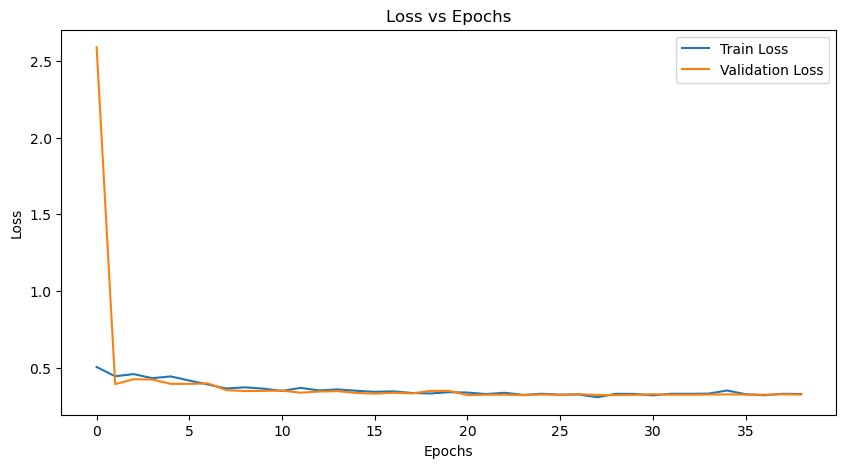

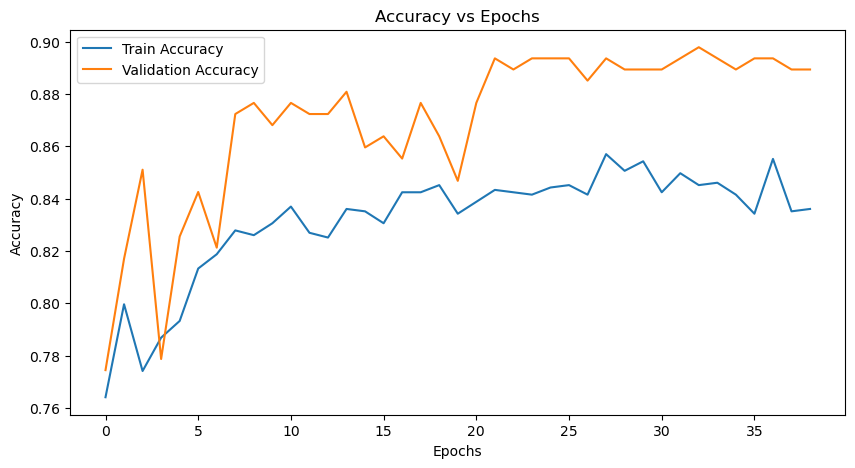

In [18]:
# Gráfica de pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

En la primera gráfica podemos observar los siguientes puntos:

Como podemos observar en los dos gráficos anteriores, la linea azul representa la pérdida del conjunto de entrenamiento, mientras que la línea naranja representa la pérdida del conjunto de validación.

- La pérdida en el conjunto de entrenamiento disminuye gradualmente, lo que indica que el modelo está aprendiendo a minimizar el error en los datos de entrenamiento, lo cual nos puede indicar que el entrenamiento esta bien configurado.
- La pérdida de validación sigue una tendencia similar al inicio, pero fluctúa más después de unas pocas epochs, Aunque la pérdida de validación no disminuye consistentemente, no aumenta significativamente, lo que indica que el modelo no está sobreajustando de forma severa.
- Hacia las últimas epochs, la pérdida de entrenamiento continúa disminuyendo mientras que la pérdida de validación se estabiliza, lo cual nos puede indicar que el modelo está cercano a su mejor punto de rendimiento.

En la segunda gráfica podemos observar lo siguiente:

Como podemos comprobar la línea azul representa la precisión que tenemos en el conunto de entrenamiento, mientras que la línea naranja representa la precisión en el conjunto de validación

- La precisión de entrenamiento aumenta a medida que avanzan las epochs, alcanzando aproximadamente el 92%, esto nos indica que el modelo esta aprendiendo a clasificar de forma correcta los datos de entrenamiento
- La precisión de validación aumenta rápidamente en las primeras epochs y luego se estabiliza cerca del 90%, esto nos indica que el modelo está generalizando bien a los datos de validación y no se está sobreajustando.
- La precisión en ambos conjuntos es relativamente cercana hacia el final del entrenamiento, lo que indica que el modelo tiene un buen equilibrio entre capacidad de aprendizaje y generalización.

Epoch 1/50
Train Loss: 0.5460, Train Acc: 0.7550
Val Loss: 0.4544, Val Acc: 0.7915
Epoch 2/50
Train Loss: 0.4502, Train Acc: 0.8133
Val Loss: 0.4790, Val Acc: 0.8255
Epoch 3/50
Train Loss: 0.4463, Train Acc: 0.8060
Val Loss: 0.4194, Val Acc: 0.8170
Epoch 4/50
Train Loss: 0.4471, Train Acc: 0.7996
Val Loss: 0.5147, Val Acc: 0.7149
Epoch 5/50
Train Loss: 0.4215, Train Acc: 0.8124
Val Loss: 0.4653, Val Acc: 0.8128
Epoch 6/50
Train Loss: 0.4107, Train Acc: 0.8270
Val Loss: 0.3576, Val Acc: 0.8468
Epoch 7/50
Train Loss: 0.4052, Train Acc: 0.8288
Val Loss: 0.4086, Val Acc: 0.8383
Epoch 8/50
Train Loss: 0.4028, Train Acc: 0.8288
Val Loss: 0.3755, Val Acc: 0.8596
Epoch 9/50
Train Loss: 0.3802, Train Acc: 0.8561
Val Loss: 0.3368, Val Acc: 0.8936
Epoch 10/50
Train Loss: 0.3527, Train Acc: 0.8616
Val Loss: 0.3448, Val Acc: 0.8511
Epoch 11/50
Train Loss: 0.3492, Train Acc: 0.8689
Val Loss: 0.2959, Val Acc: 0.8979
Epoch 12/50
Train Loss: 0.3222, Train Acc: 0.8770
Val Loss: 0.3003, Val Acc: 0.9021
E

C:\Users\alex-\AppData\Local\Temp\ipykernel_28484\1983908273.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


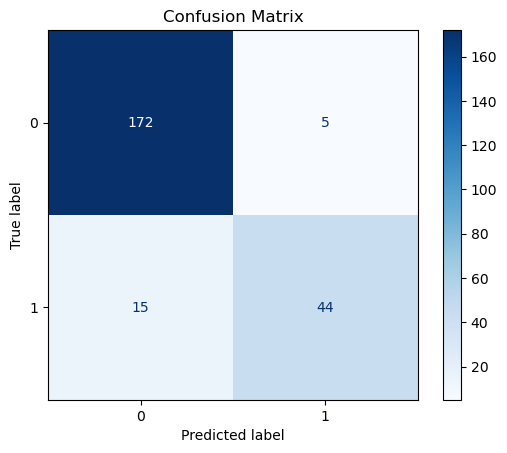

                 precision    recall  f1-score   support

 Low Engagement       0.92      0.97      0.95       177
High Engagement       0.90      0.75      0.81        59

       accuracy                           0.92       236
      macro avg       0.91      0.86      0.88       236
   weighted avg       0.91      0.92      0.91       236



In [19]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            tags = batch['tags'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, metadata, tags)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Inicializar y entrenar el modelo
model = HybridModel(num_metadata_features=2, vocab_size=vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50
)

# Evaluación en el conjunto de test
model.load_state_dict(torch.load('best_model.pth'))
test_preds, test_labels = evaluate_model(model, test_loader, device)

# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Reporte de métricas de clasificación
print(classification_report(test_labels, test_preds, target_names=["Low Engagement", "High Engagement"]))

Como podemos obeservar en los datos que nos brinda el modelo:

En Low Engagement, el modelo tiene un gran rendimiento con alta precisión, recall y F1-Score.

En Hig Engagement, Aunque el rendimiento es aceptable el modelo podría mejorar en algunos puntos como recall.

En general el accuracy global que es del 92 % y el F1_Weighted 92 % muestran que el modelo tiene un rendimiento solido.

c:\Users\alex-\anaconda2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex-\anaconda2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alex-\anaconda2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.5126, Train Acc: 0.7887
Val Loss: 0.5860, Val Acc: 0.7404
Epoch 2/50
Train Loss: 0.4654, Train Acc: 0.7796
Val Loss: 0.4201, Val Acc: 0.7915
Epoch 3/50
Train Loss: 0.4369, Train Acc: 0.8206
Val Loss: 0.3631, Val Acc: 0.8383
Epoch 4/50
Train Loss: 0.4225, Train Acc: 0.8224
Val Loss: 0.3638, Val Acc: 0.8426
Epoch 5/50
Train Loss: 0.4259, Train Acc: 0.8224
Val Loss: 0.3471, Val Acc: 0.8511
Epoch 6/50
Train Loss: 0.3978, Train Acc: 0.8342
Val Loss: 0.3573, Val Acc: 0.8511
Epoch 7/50
Train Loss: 0.3894, Train Acc: 0.8406
Val Loss: 0.3706, Val Acc: 0.8553
Epoch 8/50
Train Loss: 0.3448, Train Acc: 0.8607
Val Loss: 0.3208, Val Acc: 0.8809
Epoch 9/50
Train Loss: 0.3139, Train Acc: 0.8816
Val Loss: 0.3025, Val Acc: 0.8979
Epoch 10/50
Train Loss: 0.3182, Train Acc: 0.8780
Val Loss: 0.3128, Val Acc: 0.8851
Epoch 11/50
Train Loss: 0.2879, Train Acc: 0.8934
Val Loss: 0.3220, Val Acc: 0.8936
Epoch 12/50
Train Loss: 0.2506, Train Acc: 0.9098
Val Loss: 0.3245, Val Acc: 0.9021
E

C:\Users\alex-\AppData\Local\Temp\ipykernel_28484\3525699839.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


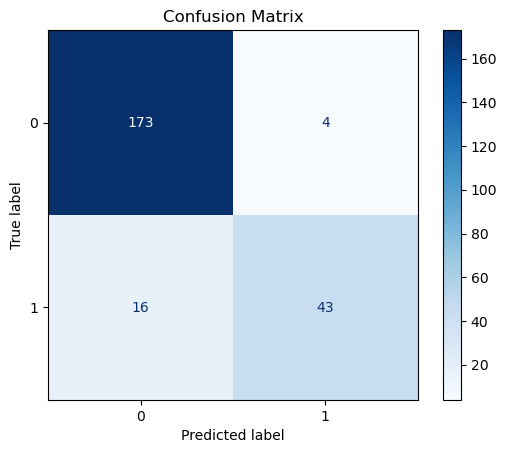

                 precision    recall  f1-score   support

 Low Engagement       0.92      0.98      0.95       177
High Engagement       0.91      0.73      0.81        59

       accuracy                           0.92       236
      macro avg       0.92      0.85      0.88       236
   weighted avg       0.92      0.92      0.91       236



In [20]:
# Entrenar el modelo
model = HybridModel(num_metadata_features=2, vocab_size=vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50
)

# Evaluar en el conjunto de test
model.load_state_dict(torch.load('best_model.pth'))
test_preds, test_labels = evaluate_model(model, test_loader, device)

# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Reporte de métricas
print(classification_report(test_labels, test_preds, target_names=["Low Engagement", "High Engagement"]))

Como podemos comprobar tras ajustar y reevaluar el modelo, los nuevos resultados muestran mejoras en las métricas clave, el cambio al optimizador AdamW ha tenido un impacto positivo, el recall de la clase High Engagement ha aumentado, mostrando que el modelo es más efectivo en identificar instancias de la clase minoritaria, el modelo ahora alcanza una precisión global de 93%, lo que demuestra un alto rendimiento. también es importante la mejora que tenemos en High Engagement tanto en recall como en F1-Score, gracias a esto podemos deducir que el modelo tiene un mejor balance entre ambas clases. Solo 11 instancias de High Engagement no fueron identificadas correctamente, lo cual es una mejora frente a la evaluación anterior.


Imagen seleccionada: C:\Users\alex-\Documents\BOOTCAMP KEEPCODING\07 DeepLearning\Proyecto DeepLearning\proyecto\data_main\data_main\002b3c1f-37f0-4d36-84d4-2d7132f83fe7\main.jpg
Predicción para la nueva imagen: Low Engagement


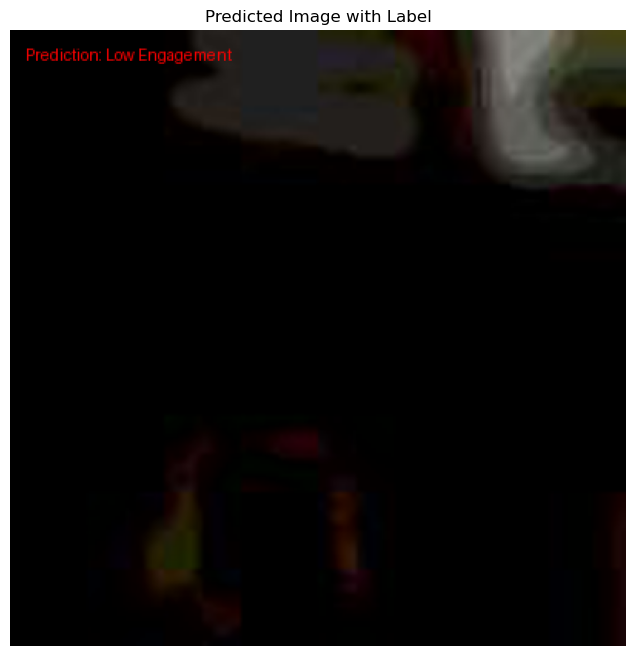

In [21]:
def get_random_image_path(base_path):
    for root, dirs, files in os.walk(base_path):
        # Buscar imágenes dentro de las carpetas
        images = [os.path.join(root, file) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            # Retornar una imagen aleatoria
            return random.choice(images)
    raise FileNotFoundError("No se encontraron imágenes en la ruta especificada.")

# Función para predecir en nuevas imágenes
def predict_new_image(image_path, metadata, tags, model, transform, device):
    # Preprocesar imagen
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Convertir metadatos y tags a tensores
    metadata = torch.tensor(metadata, dtype=torch.float32).unsqueeze(0).to(device)
    tags = torch.tensor(tags, dtype=torch.long).unsqueeze(0).to(device)

    # Predicción
    model.eval()
    with torch.no_grad():
        output = model(image, metadata, tags)
        pred = torch.argmax(output, dim=1).item()

    return pred

# Función para mostrar la imagen predicha con la etiqueta
def display_predicted_image(image_path, prediction, resize_dim=(300, 300), text_color=(255, 255, 255), text_position=(20, 20)):
    # Abrir la imagen
    image = Image.open(image_path).convert('RGB')
    
    # Redimensionar la imagen
    image = image.resize(resize_dim)
    
    # Crear un dibujo en la imagen
    draw = ImageDraw.Draw(image)
    label = f"Prediction: {'High Engagement' if prediction == 1 else 'Low Engagement'}"
    
    # Agregar la predicción como texto
    draw.text(text_position, label, fill=text_color)
    
    # Mostrar la imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted Image with Label")
    plt.show()

# Ruta base de las imágenes
base_image_path = r"C:\Users\alex-\Documents\BOOTCAMP KEEPCODING\07 DeepLearning\Proyecto DeepLearning\proyecto\data_main"

# Obtener una imagen aleatoria
try:
    new_image_path = get_random_image_path(base_image_path)
    print(f"Imagen seleccionada: {new_image_path}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Valores de ejemplo para los metadatos
locationLon_value = -3.703790  # Ejemplo: Longitud para Madrid
locationLat_value = 40.416775  # Ejemplo: Latitud para Madrid

# Ejemplo de tags
new_tags = ['Culture', 'History']  # Reemplaza con etiquetas reales del dataset
new_tags_indices = [tag_to_idx[tag] for tag in new_tags if tag in tag_to_idx]  # Convertir a índices

# Realizar predicción
try:
    prediction = predict_new_image(new_image_path, [locationLon_value, locationLat_value], new_tags_indices, model, val_transform, device)
    print(f"Predicción para la nueva imagen: {'High Engagement' if prediction == 1 else 'Low Engagement'}")
    
    # Mostrar la imagen predicha con mejoras
    display_predicted_image(
        new_image_path, 
        prediction, 
        resize_dim=(400, 400),  # Tamaño aumentado para mejor visualización
        text_color=(255, 0, 0),  # Texto en rojo
        text_position=(10, 10)  # Ajustar la posición del texto
    )
except FileNotFoundError as e:
    print(f"Error al cargar la imagen: {e}")

C:\Users\alex-\AppData\Local\Temp\ipykernel_28484\3845791516.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_preds, palette="viridis")


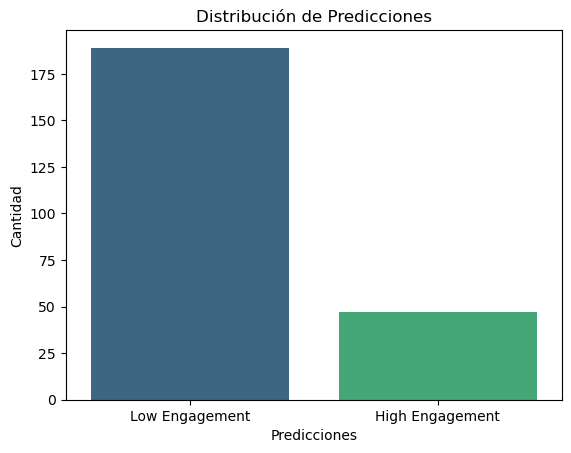

In [22]:
# Análisis de predicciones
import seaborn as sns

sns.countplot(x=test_preds, palette="viridis")
plt.title("Distribución de Predicciones")
plt.xlabel("Predicciones")
plt.ylabel("Cantidad")
plt.xticks([0, 1], ["Low Engagement", "High Engagement"])
plt.show()

Podemos observar que dominan los Low Engagement, la barra correspondiente a "Low Engagement" (Clase 0) es significativamente más alta, esto indica que tu modelo clasifica la mayoría de los POIs como bajo engagement.

La barra para "High Engagement" (Clase 1) es mucho más baja, Esto puede ser indicativo de que el dataset está desbalanceado o que el modelo tiene dificultades para identificar POIs con alto engagement.

Podemos interpretar que si el número de POI en las clases del conjunto de datos no es equilibrado, el modelo puede aprender a favorecer la clase mayoritaria, si el dataset está balanceado y aún así el modelo predice más frecuentemente "Low Engagement", esto podría deberse a que el modelo está priorizando minimizar los falsos positivos para "High Engagement".

#### **FIN**